<a href="https://colab.research.google.com/github/Cristian2820/Senales-y-sistemas/blob/main/Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2024-09-30 22:52:50--  https://docs.google.com/uc?export=download&confirm=&id=18S3b3P2ApgTJMCdP6KBS5P0mQpJ5A4iz
Resolving docs.google.com (docs.google.com)... 173.194.217.138, 173.194.217.101, 173.194.217.100, ...
Connecting to docs.google.com (docs.google.com)|173.194.217.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=18S3b3P2ApgTJMCdP6KBS5P0mQpJ5A4iz&export=download [following]
--2024-09-30 22:52:50--  https://drive.usercontent.google.com/download?id=18S3b3P2ApgTJMCdP6KBS5P0mQpJ5A4iz&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.26.132, 2607:f8b0:400c:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.26.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12402 (12K) [application/octet-stream]
Saving to: ‘Educador.xlsx’

Educador.xlsx       100%[===================>]  12.11K  --.-KB

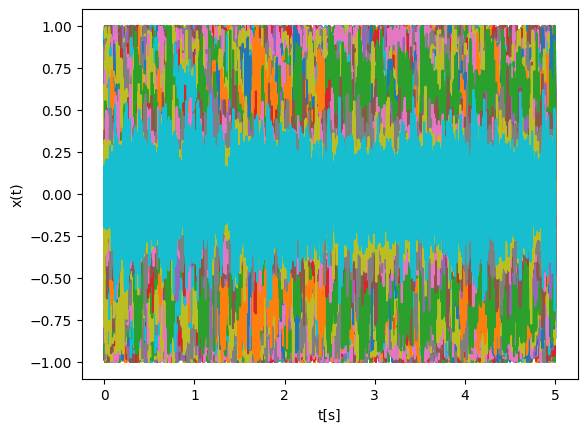

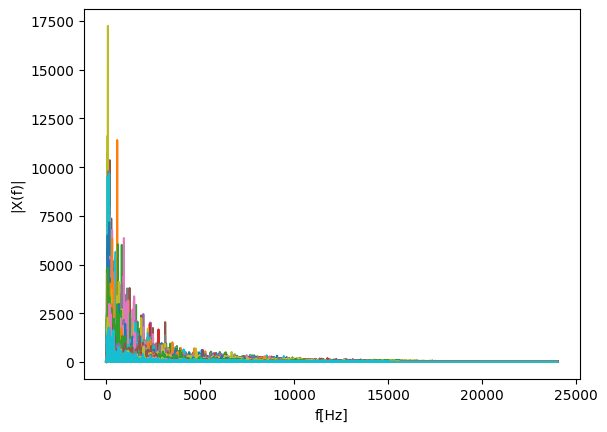

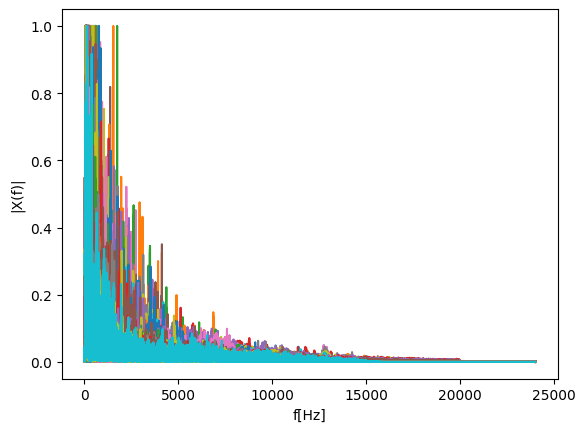

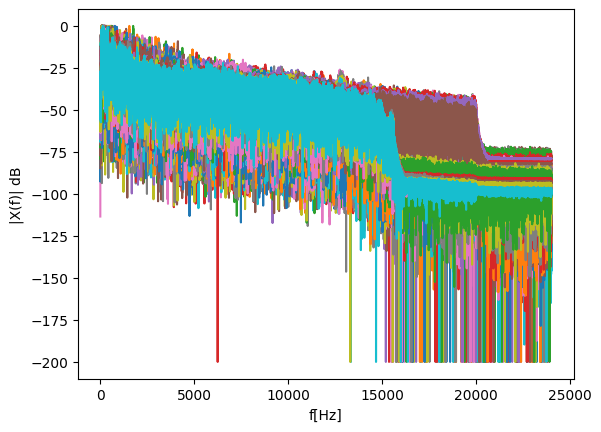

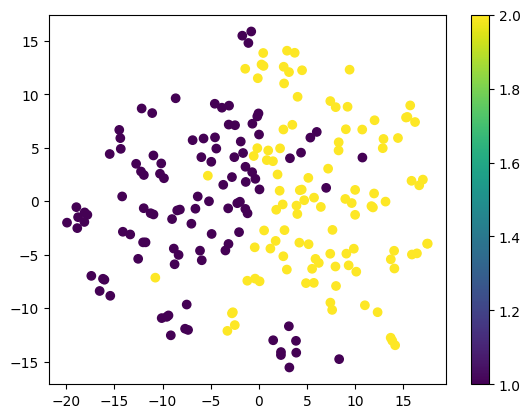

Classification Report:
               precision    recall  f1-score   support

         1.0       0.86      1.00      0.93        19
         2.0       1.00      0.87      0.93        23

    accuracy                           0.93        42
   macro avg       0.93      0.93      0.93        42
weighted avg       0.94      0.93      0.93        42

Confusion Matrix:
 [[19  0]
 [ 3 20]]


FileExistsError: [Errno 17] File exists: 'modelo'

In [44]:
# Cargar datos desde Drive acceso libre
FILEID = "18S3b3P2ApgTJMCdP6KBS5P0mQpJ5A4iz"

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O  Educador.xlsx && rm -rf /tmp/cookies.txt
#!unzip -o codigos.zip
!dir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

file_ = 'Educador.xlsx'#leer archivo xlsx con link, band, type
X  = pd.read_excel(file_)
# imprimir filas iniciales

# Instalar librerías necesarias para descargar audios de YouTube
!python3 -m pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz
!pip install soundfile

import os
import yt_dlp as youtube_dl

# Función para descargar mp3 desde youtube
def download_ytvid_as_mp3(video_url, name):
    video_info = youtube_dl.YoutubeDL().extract_info(url=video_url, download=False)
    filename = f"{name}.mp3"
    options = {
        'format': 'bestaudio/best',
        'keepvideo': False,
        'outtmpl': filename,
    }

    with youtube_dl.YoutubeDL(options) as ydl:
        ydl.download([video_info['webpage_url']])

    print("Download complete... {}".format(filename))

import subprocess

# Crear carpeta con resultados
try:
    os.mkdir('results')
except:
    print("Carpeta results ya existe")

# Recorrer excel con videos
N, P = X.shape
Ns = N * 5  # cantidad de segmentos por canción

for n in range(N):
    print(f"video {n + 1} de {N}")
    print(f"link: {X.loc[n, 'link']}\n")
    print(f"band: {X.loc[n, 'band']}\n")
    print(f"type: {X.loc[n, 'type']}\n")
    # ruta video n-th
    name_ = 'results/' + X.loc[n, 'band'] + "_" + str(n) + "_" + str(X.loc[n, 'type_num'])  # video + nombre + tipo de género musical
    # descargar mp3 desde youtube
    download_ytvid_as_mp3(X.loc[n, 'link'], name_)
    # convertir a .wav
    subprocess.call(['ffmpeg', '-y', '-i', name_ + '.mp3', name_ + '.wav'])

# Cargar .wavs y partir audios
# lista archivos .wav
path = 'results/'
wav_files = [f for f in os.listdir(path) if f.endswith('.wav')]
wav_files

import soundfile as sf  # para instalar pip install soundfile

# Leer archivos y crear np.array audios
fs = 48000
tl = np.array([40, 50, 60, 70, 80, 90, 100])  # puntos lectura
ts = 5  # tiempo segmento
Ns = len(wav_files) * len(tl)  # cantidad segmentos
x_t = np.zeros((Ns, int(ts * fs), 2))  # Ns segmentos, cantidad de muestras, 2 canales (stereo)
label = np.zeros((Ns, 1))  # vector tipo de género
name_c = []

# Leer archivos wav
i = 0
for name in wav_files:  # lectura audio .wav
    x, fs = sf.read(path + name)
    for ti in tl:  # segmentos de tiempo
        x_t[i] = x[int(fs * ti):int(fs * (ti + ts)), :]
        label[i] = int(name[-5])  # tipo de género
        name_c += [name[:-6]]
        print(f"{i} lectura: {name}; segundo {ti}:{ti + ts}; tipo música {label[i]}")
        i += 1
x_t.shape

from IPython.display import Audio  # reproducir segmento
i = 10
Audio(x_t[i].T, rate=fs)

# Cálculo de Fourier
vf = np.fft.rfftfreq(x_t.shape[1], 1/fs)  # cálculo vector de frecuencias
Xw = np.fft.rfft(x_t, axis=1).mean(axis=-1)  # transformada rápida de Fourier para señal Real a lo largo del tiempo (axis=1) y se promedian los dos canales
Xw.shape

# Gráfica tiempo y Fourier
plt.plot(np.arange(0, ts, 1/fs), x_t.mean(axis=-1).T)  # se promedian los dos canales stereo
plt.xlabel('t[s]')
plt.ylabel('x(t)')
plt.show()

plt.plot(vf, abs(Xw).T)
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)|')
plt.show()

# Se normalizan espectros entre 0 y 1 para evitar inconsistencias por amplitudes máximas
from sklearn.preprocessing import MinMaxScaler

sca = MinMaxScaler()
Xw_ = sca.fit_transform(abs(Xw).T).T

plt.plot(vf, Xw_.T)
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)|')
plt.show()

# En dB
plt.plot(vf, (20 * np.log10(Xw_ + 1e-10)).T)  # se suma 1e-10 para evitar discontinuidad del log
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)| dB')
plt.show()

from sklearn.manifold import TSNE
# Visualización de datos
red_ = TSNE(perplexity=20, n_components=2, random_state=123, learning_rate='auto', init='pca')
fmax = 7000
X_2D = red_.fit_transform(Xw_[:, :fmax])  # se tiene en cuenta el espectro hasta fmax Hz

# Graficar separabilidad 2D
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=label)
plt.colorbar()
plt.show()

# Entrenamiento del modelo
X_train, X_test, y_train, y_test = train_test_split(Xw_, label, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train.ravel())  # Ajustar el modelo

# Evaluar el modelo
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Reproducir audio
i = 96
Audio(x_t[i].T, rate=fs)

i = 14
Audio(x_t[i].T, rate=fs)

import joblib

# Guardar modelo
os.mkdir('modelo')
filename_ = 'modelo/Rock_vs_Salsa'
model_ = {'Xw_': Xw_, 'fmax': fmax, 'label': label, 'name_c': name_c, 'vf': vf, 'fs': fs, 'model': model}
joblib.dump(model_, filename_ + ".pkl")




In [ ]:
from google.colab import files

# Descargar el archivo del modelo
files.download(filename_ + ".pkl")

In [45]:
!pip install streamlit -q
!npm install localtunnel
!python3 -m pip install --force-reinstall https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz
!pip install pyngrok
!pip install sympy --upgrade
!pip install yt-dlp
!pip install soundfile
!pip install librosa
!pip install gdown
!pip install pytube
!pip install --upgrade pytube
!apt-get install ffmpeg
!pip install pandas gspread oauth2client
!pip install streamlit yt-dlp soundfile numpy matplotlib scipy pandas


up to date, audited 23 packages in 741ms

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
  Using cached https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Brotli-1.1.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.5 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
  Using cached mutagen-1.47.0-py3-none-any.whl.metadata (1.7 kB)
  Using cached pycryptodomex-3.20.0-cp35-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
  Using cached websoc

In [46]:
%%writefile Punto2.py
import streamlit as st
import numpy as np
import soundfile as sf
import io
import matplotlib.pyplot as plt

# Título de la aplicación
st.title("Clasificación de Canciones")

# Sección para cargar la canción
uploaded_file = st.file_uploader("Cargar Canción", type=["wav", "mp3"])

if uploaded_file is not None:
    # Leer el archivo de audio
    x, fs = sf.read(uploaded_file)

    # Calcular características
    energy = np.sum(x ** 2)  # Energía de la señal
    duration = len(x) / fs   # Duración de la canción en segundos

    # Mostrar características en la interfaz
    st.subheader("Características de la Canción")
    st.write(f"Energía: {energy:.2f}")
    st.write(f"Duración: {duration:.2f} segundos")

    # Clasificación (simple ejemplo)
    if energy > 1.0:  # Ajusta este umbral según tu criterio
        genre = "Rock"
    else:
        genre = "Pop"

    st.write(f"Género estimado: {genre}")

    # Reproducir la canción
    audio_buffer = io.BytesIO()
    sf.write(audio_buffer, x, fs, format='WAV')  # Guardar en un buffer
    audio_buffer.seek(0)
    st.audio(audio_buffer, format='audio/wav')  # Reproducir

    # Gráfica de la señal de audio
    st.subheader("Gráfica de la Señal de Audio")
    plt.figure(figsize=(10, 4))
    plt.plot(x)
    plt.title("Señal de Audio")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    st.pyplot(plt)


Overwriting Punto2.py


In [47]:
token="2lmAC6DGxB9xF06bq6Js7K7IZQK_5T6aE4rBZBp6hDqefow8M"

In [48]:
from pyngrok import ngrok

# # Set authentication token (unique per user)
ngrok.set_auth_token(token)

# # Start Streamlit server on a specific port
!nohup streamlit run Punto2.py --server.port 5050 &

# # Start ngrok tunnel to expose the Streamlit server
ngrok_tunnel = ngrok.connect(addr='5050', proto='http', bind_tls=True)

# # Print the URL of the ngrok tunnel
print(' * Tunnel URL:', ngrok_tunnel.public_url)

nohup: appending output to 'nohup.out'
 * Tunnel URL: https://6add-34-74-223-152.ngrok-free.app
